# Enoncé

Bienvenue dans le TP noté du chapitre Deep Learning. Vous allez ici devoir faire la compétition [Chien VS Chat de Kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard). Vous aurez pour cela deux jours et pouvez vous mettre par équipe (2 maximum).

Ce TP a été réalisé avec la librairie Keras qui va vous permettre de créer et d'entrainer des réseaux de neurones facilement. 
Nous avons également utilisé Tensorboard qui vous permettra de visualiser vos courbes d'apprentissage en semi temps réel. Pour démarrer Tensorboard, démarrez un nouveau Anaconda Prompt, placez-vous dans le même répertoire que ce notebook et exécutez :
```
tensorboard --logdir=Graph
```
Accèdez ensuite à l'url indiqué sur le prompt depuis votre navigateur.


Voici l'énoncé de ce que vous allez devoir faire :

1. Commencez par installer la libraire python OpenCV. Pour cela, arrêtez votre `jupyter lab` et exécutez dans votre Anaconda Prompt `pip install cv2`. Vous pouvez ensuite relancer votre `jupyter lab`.
2. Télécharger maintenant les zip de train et de test depuis la compétition Kaggle. Une fois cela fait, dézipé les dans le dossier _datasets_.
3. Le code suivant commence par charger ces images et les normaliser. Il crée également nos labels. Vous allez pouvoir réutiliser cette partie tout au long de ce TP.
4. Nous vous avons ensuite proposé un réseau de neurones (convolutif). Cependant, il est loin d'être optimal (score de 4.01 sur Kaggle). __A vous de l'améliorer !__ Pour cela, vous allez devoir appliquer ce que nous avons vu en cours. Pour rappel, vous pouvez modifier différentes choses :
  - pour les données : Data Augmentation (utiliser Keras pour cela)
  - pour l'architecture du réseau : La taille des kernels, le nombre de couches (de convolution et de feedforward), la taille de ces couches, l'optimizer, le dropout et la régularisation en cas d'overfitting (un indice : c'est le cas ici !)...
  - pour l'apprentissage : le nombre d'epoch, le batch_size, mettre en place du early stopping...
  - Voir même du Transfer Learning à partir d'un réseau déjà entrainé ! (par exemple comme dans [cet article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html))
5. Enfin, nous avons déjà implémenté la partie _Predict_, qui correspond à l'utilisation du modèle sur le jeu de données de test et la création du fichier csv à donner à Kaggle.

Votre objectif est simple, obtenez le meilleur réseau de neurones possible ! Et surtout amusez-vous, essayez différentes techniques et n'hésitez pas à regarder les Kernels proposés sur Kaggle pour vous en inspirer.

__Rendu__ : Vous devrez faire une présentation de quelques minutes pour nous expliquer votre travail, vos résultats, et votre retour (qu'est-ce que vous avez bien/mal fait, qu'est-ce que vous feriez différemment, les pistes d'améliorations...). Vous devrez également nous envoyer votre notebook __commenté__ !

Bonne chance !

----

# TP

In [255]:
import os, random
import datetime
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import np_utils
from keras import backend

## Import Data

### Images

#### Import

In [3]:
TRAIN_DIR = 'datasets/train/'
TEST_DIR = 'datasets/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [199]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image # nos données sont de la forme (64, 64, 3)
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data


In [200]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 25000
Processed 250 of 25000
Processed 500 of 25000
Processed 750 of 25000
Processed 1000 of 25000
Processed 1250 of 25000
Processed 1500 of 25000
Processed 1750 of 25000
Processed 2000 of 25000
Processed 2250 of 25000
Processed 2500 of 25000
Processed 2750 of 25000
Processed 3000 of 25000
Processed 3250 of 25000
Processed 3500 of 25000
Processed 3750 of 25000
Processed 4000 of 25000
Processed 4250 of 25000
Processed 4500 of 25000
Processed 4750 of 25000
Processed 5000 of 25000
Processed 5250 of 25000
Processed 5500 of 25000
Processed 5750 of 25000
Processed 6000 of 25000
Processed 6250 of 25000
Processed 6500 of 25000
Processed 6750 of 25000
Processed 7000 of 25000
Processed 7250 of 25000
Processed 7500 of 25000
Processed 7750 of 25000
Processed 8000 of 25000
Processed 8250 of 25000
Processed 8500 of 25000
Processed 8750 of 25000
Processed 9000 of 25000
Processed 9250 of 25000
Processed 9500 of 25000
Processed 9750 of 25000
Processed 10000 of 25000
Processed 10250 of 25

### Normalization

In [201]:
def normalize_images(images):
    recaled_images = images/255
    return recaled_images

In [206]:
scaled_train = normalize_images(train)
scaled_test = normalize_images(test)

### Labels

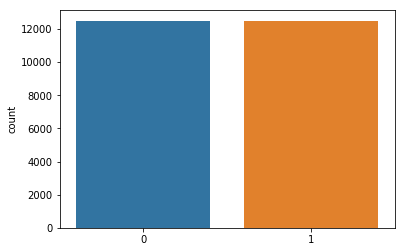

In [207]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

### Plot

In [208]:
def plot_image(idx):
    print("Label : " + str(labels[idx]))
    plt.imshow(scaled_train[idx])
    plt.show()

In [209]:
ramdom_samples = np.random.randint(0, len(scaled_train), 5)

Label : 1


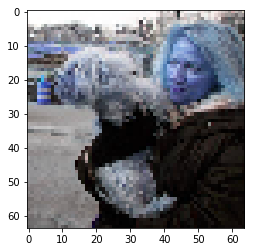

Label : 1


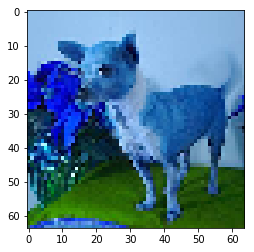

Label : 0


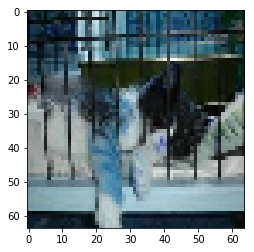

Label : 1


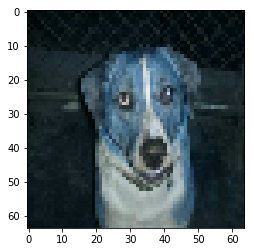

Label : 0


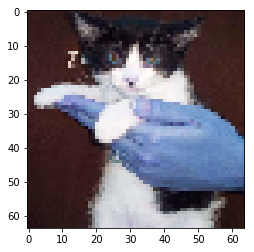

In [210]:
for i in ramdom_samples:
    plot_image(i)

## Model

In [226]:
def model():
    backend.clear_session()
    model = Sequential()
    
    ###### Architecture ######
    ##### Conv Layer 1 #####
    model.add(Convolution2D(filters=32,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same', 
                            input_shape=(ROWS, COLS, CHANNELS), 
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### Conv Layer 2 #####
    model.add(Convolution2D(filters=64,
                            kernel_size=(3, 3), 
                            strides=(1, 1),
                            padding='same',  
                            activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=((2, 2))))
    
    ##### FeedForward #####
    ## Hidden 1
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    ## Output
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    ###### Training ######
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model   

## Training

In [263]:
nb_epoch = 10
batch_size = 16

On log à chaque Epoch la loss et l'accuracy pour le train et la validation (avec comme nom la date ci-dessous)

In [267]:
model_name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

In [268]:
tensorboard_callback = TensorBoard(log_dir='./Graph/' + model_name, write_graph=True, write_images=True)

On sauvegarde le model à chaque Epoch si on a eu une amélioration sur l'accuracy du jeu de validation

In [270]:
filepath="Models/" + model_name + "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [271]:
def train_model(model):
    model.fit(scaled_train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[tensorboard_callback, checkpoint])

In [272]:
first_model = model()

In [273]:
first_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
__________

In [274]:
train_model(first_model)

D:\Programmes\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 18750 samples, validate on 6250 samples
Epoch 1/1
18750/18750 [==============================] - 95s - loss: 0.5624 - acc: 0.7178 - val_loss: 0.7727 - val_acc: 0.5603


## Prediction

In [241]:
predictions = first_model.predict(scaled_test, verbose=1)

12448/12500 [============================>.] - ETA: 0s

In [251]:
final_df = pd.concat([
    pd.Series(range(1, len(test)+1), name='id'),
    pd.Series(predictions[:, 0], name='label')
], axis=1)

In [252]:
final_df.to_csv('test_submission.csv', index=False)